# **Oneline Retail Customer Segmentation**

  In this assignment, I will perform segmentation of online retail customers based on cohort and RFM clustering. The data set contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

In [3]:
import datetime as dt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns

import squarify
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Import datasets
data = pd.read_csv("OnlineRetail.csv",sep=",", encoding="ISO-8859-1", header=0)
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


# **Data Cleansing**

In [5]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
data = data.dropna()
data.shape

(406829, 8)

In [7]:
#checking for duplicates
data.duplicated().sum()

5225

In [8]:
#removing duplicates
data.drop_duplicates(keep='first', inplace=True)
data.shape

(401604, 8)

In [9]:
#let's do a copy of our df for next manipulations
retail = data.copy()

# **Exploratory Data Analysis**

In [10]:
#calculate revenue per row and add new column
retail['Revenue'] = retail['Quantity'] * retail['UnitPrice']

In [11]:
retail.InvoiceDate = pd.to_datetime(retail['InvoiceDate'], format='%d-%m-%Y %H:%M')

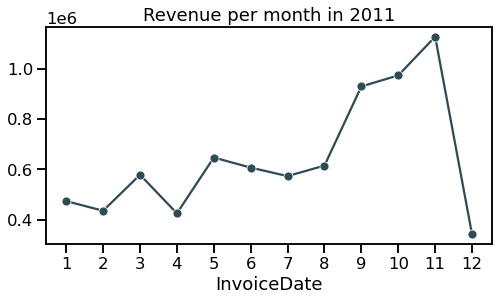

In [12]:
# Let's visualize the top grossing months
retail_month = retail[retail.InvoiceDate.dt.year==2011]
monthly_gross = retail_month.groupby(retail_month.InvoiceDate.dt.month).Revenue.sum()

plt.figure(figsize=(8,4))
sns.set_context("talk")
sns.set_palette("PuBuGn_d")
sns.lineplot(y=monthly_gross.values,x=monthly_gross.index, marker='o')
plt.xticks(range(1,13))
plt.title("Revenue per month in 2011")
plt.show()

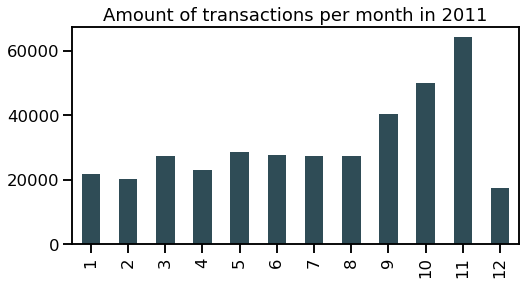

In [13]:
#amount of transactions per month
plt.figure(figsize=(8,4))
retail[retail.InvoiceDate.dt.year==2011].InvoiceDate.dt.month.value_counts(sort=False).plot(kind='bar')
plt.title("Amount of transactions per month in 2011")
plt.show()

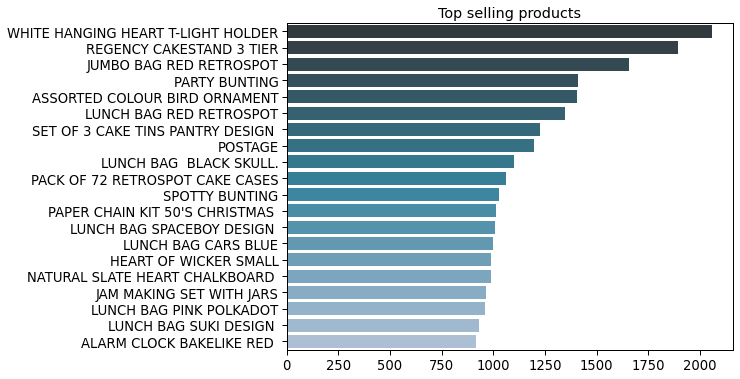

<Figure size 432x288 with 0 Axes>

In [14]:
# Let's visualize some top products from the whole range
top_products = retail['Description'].value_counts()[:20]
plt.figure(figsize=(8,6))
sns.set_context("paper", font_scale=1.5)
sns.barplot(y = top_products.index,
            x = top_products.values, 
           palette='PuBuGn_d')
plt.title("Top selling products")
plt.show()
plt.savefig('top_products.png')

# **Cohort Analysis**

Assign acquisition month cohort to each customer

In [15]:
#creating invoice month column to see first month when customer purchased 
retail['InvoiceMonth'] = retail['InvoiceDate'].apply(lambda x: dt.datetime(x.year, x.month, 1))

In [16]:
grouping = retail.groupby('CustomerID')['InvoiceMonth']
#assign smallest invoice value to each customer
retail['CohortMonth'] = grouping.transform('min')
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,InvoiceMonth,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01


In [17]:
#function to extract year, month, day as integers
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

In [18]:
#extract month
invoice_year, invoice_month, _ = get_date_int(retail, 'InvoiceMonth')
cohort_year, cohort_month, _ = get_date_int(retail, 'CohortMonth')

In [19]:
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month

In [20]:
# Extract the difference in days from all previous values
retail['CohortIndex'] = years_diff * 12 + months_diff + 1
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1


In [21]:
#count monthly active customers from each cohort
grouping = retail.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth', columns = 'CohortIndex', values='CustomerID')

In [22]:
#Customer retention
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention = retention.round(3) * 100
retention.head(20)

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,38.2,33.4,38.7,36.0,39.7,38.0,35.4,35.4,39.5,37.3,50.0,27.4
2011-01-01,100.0,24.0,28.3,24.2,32.8,29.9,26.1,25.7,31.1,34.7,36.8,15.0,NaN
2011-02-01,100.0,24.7,19.2,27.9,26.8,24.7,25.5,28.2,25.8,31.3,9.2,NaN,NaN
2011-03-01,100.0,19.1,25.5,21.8,23.2,17.7,26.4,23.9,28.9,8.9,NaN,NaN,NaN
2011-04-01,100.0,22.7,22.1,21.1,20.7,23.7,23.1,26.1,8.4,NaN,NaN,NaN,NaN
2011-05-01,100.0,23.7,17.2,17.2,21.5,24.4,26.5,10.4,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,20.9,18.7,27.2,24.7,33.6,10.2,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,20.9,20.4,23.0,27.2,11.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,25.1,25.1,25.1,13.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


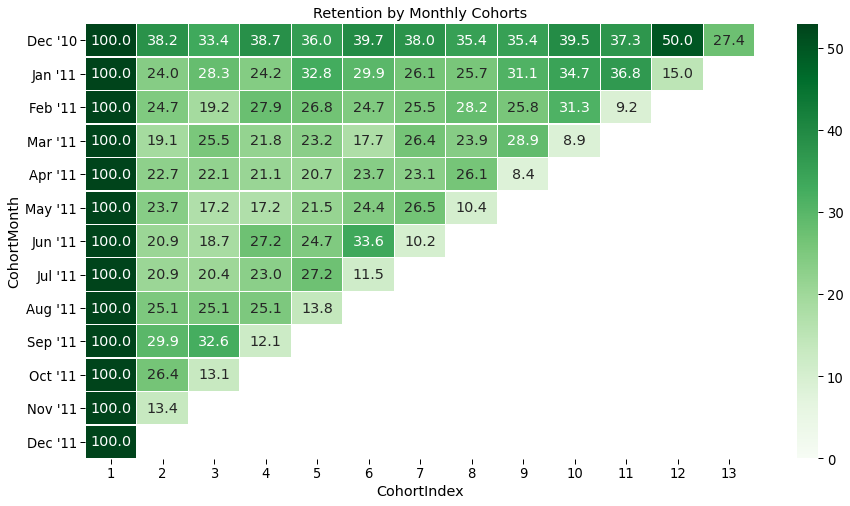

In [23]:
month_list = ["Dec '10", "Jan '11", "Feb '11", "Mar '11", "Apr '11",\
              "May '11", "Jun '11", "Jul '11", "Aug '11", "Sep '11", \
              "Oct '11", "Nov '11", "Dec '11"]

plt.figure(figsize=(15,8))
plt.title('Retention by Monthly Cohorts')
sns.heatmap(data=retention,
            annot = True,
            cmap = "Greens",
            vmin = 0.0,
            vmax = list(retention.max().sort_values(ascending = False))[1]+3,
            fmt = '.1f',
            linewidth = 0.3,
            yticklabels=month_list)

plt.show()

# **RFM analysis**

Determine which customers are high-value customers by examining how recently a customer has purchased (recency), how often they purchase (frequency), and how much the customer spends (monetary)

In [24]:
#12 months of data
print('Min:{}; Max:{}'.format(min(retail.InvoiceDate), max(retail.InvoiceDate)))

Min:2010-12-01 08:26:00; Max:2011-12-09 12:50:00


In [25]:
#calculate revenue per row and add new column
retail['MonetaryValue'] = retail['Quantity'] * retail['UnitPrice']

In [26]:
#let's look at amount spend per customer (revenue contributed) M-Monetary
retail_mv = retail.groupby(['CustomerID']).agg({'MonetaryValue': sum}).reset_index()
retail_mv.head()

,CustomerID,MonetaryValue
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [27]:
#F-frequency (how many purchases each customer made)
retail_f = retail.groupby('CustomerID')['InvoiceNo'].count()
retail_f = retail_f.reset_index()
retail_f.head()

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [28]:
#merge previous dataframes together (mv+f)
retail_mv_f = pd.merge(retail_mv, retail_f, on='CustomerID', how='inner')
retail_mv_f.head()

,CustomerID,MonetaryValue,InvoiceNo
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [29]:
#R-recency 
#last transaction date 

retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')
max_date = max(retail['InvoiceDate'])

#difference between last date and transaction date
retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,InvoiceMonth,CohortMonth,CohortIndex,MonetaryValue,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,2010-12-01,1,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,2010-12-01,1,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1,20.34,373 days 04:24:00


In [30]:
#recency per customer (last transaction date)
retail_r = retail.groupby('CustomerID')['Diff'].min()
retail_r = retail_r.reset_index()

# Extract number of days only
retail_r['Diff'] = retail_r['Diff'].dt.days

In [31]:
#merge R dataframe with FM

retail_rfm = pd.merge(retail_mv_f, retail_r, on='CustomerID', how='inner')
retail_rfm.columns = ['CustomerID', 'MonetaryValue', 'Frequency', 'Recency']
retail_rfm.head()

,CustomerID,MonetaryValue,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [32]:
cols = retail_rfm.columns.tolist()
cols

['CustomerID', 'MonetaryValue', 'Frequency', 'Recency']

In [33]:
#changed columns order
cols = ['CustomerID', 'Recency', 'Frequency', 'MonetaryValue']
retail_rfm = retail_rfm[cols]
retail_rfm.head()

,CustomerID,Recency,Frequency,MonetaryValue
0,12346.0,325,2,0.00
1,12347.0,1,182,4310.00
2,12348.0,74,31,1797.24
3,12349.0,18,73,1757.55
4,12350.0,309,17,334.40


In [34]:
max(retail_rfm['Recency'])

373

In [35]:
min(retail_rfm['Recency'])

0

In [36]:
max(retail_rfm['Frequency'])

7812

In [37]:
min(retail_rfm['Frequency'])

1

In [38]:
max(retail_rfm['MonetaryValue'])

279489.0199999999

In [39]:
min(retail_rfm['MonetaryValue'])

-4287.63

In [40]:
# create labels and assign them to tree percentile groups 
r_labels = range(4, 0, -1)
r_groups = pd.qcut(retail_rfm.Recency, q = 4, labels = r_labels)
f_labels = range(1, 5)
f_groups = pd.qcut(retail_rfm.Frequency, q = 4, labels = f_labels)
m_labels = range(1, 5)
m_groups = pd.qcut(retail_rfm.MonetaryValue, q = 4, labels = m_labels)

In [41]:
# make a new column for group labels
retail_rfm['R'] = r_groups.values
retail_rfm['F'] = f_groups.values
retail_rfm['M'] = m_groups.values
# sum up the three columns
retail_rfm['RFM_Segment'] = retail_rfm.apply(lambda x: str(x['R']) + str(x['F']) + str(x['M']), axis = 1)
retail_rfm['RFM_Score'] = retail_rfm[['R', 'F', 'M']].sum(axis = 1)
retail_rfm.head()

,CustomerID,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
0,12346.0,325,2,0.00,1,1,1,111,3.0
1,12347.0,1,182,4310.00,4,4,4,444,12.0
2,12348.0,74,31,1797.24,2,2,4,224,8.0
3,12349.0,18,73,1757.55,3,3,4,334,10.0
4,12350.0,309,17,334.40,1,1,2,112,4.0


In [42]:
# assign labels from total score
score_labels = ['Green', 'Bronze', 'Silver', 'Gold']
score_groups = pd.qcut(retail_rfm.RFM_Score, q = 4, labels = score_labels)
retail_rfm['RFM_Level'] = score_groups.values
retail_rfm.sort_values(by='RFM_Score', ascending=False)
retail_rfm.head(10)

,CustomerID,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,RFM_Level
0,12346.0,325,2,0.00,1,1,1,111,3.0,Green
1,12347.0,1,182,4310.00,4,4,4,444,12.0,Gold
2,12348.0,74,31,1797.24,2,2,4,224,8.0,Silver
3,12349.0,18,73,1757.55,3,3,4,334,10.0,Silver
4,12350.0,309,17,334.40,1,1,2,112,4.0,Green
5,12352.0,35,95,1545.41,3,3,3,333,9.0,Silver
6,12353.0,203,4,89.00,1,1,1,111,3.0,Green
7,12354.0,231,58,1079.40,1,3,3,133,7.0,Bronze
8,12355.0,213,13,459.40,1,1,2,112,4.0,Green
9,12356.0,22,59,2811.43,3,3,4,334,10.0,Silver


In [43]:
retail_rfm_levels = retail_rfm.groupby('RFM_Level')['CustomerID'].count().reset_index(name='counts')
retail_rfm_levels.head()

,RFM_Level,counts
0,Green,1298
1,Bronze,908
2,Silver,1322
3,Gold,844


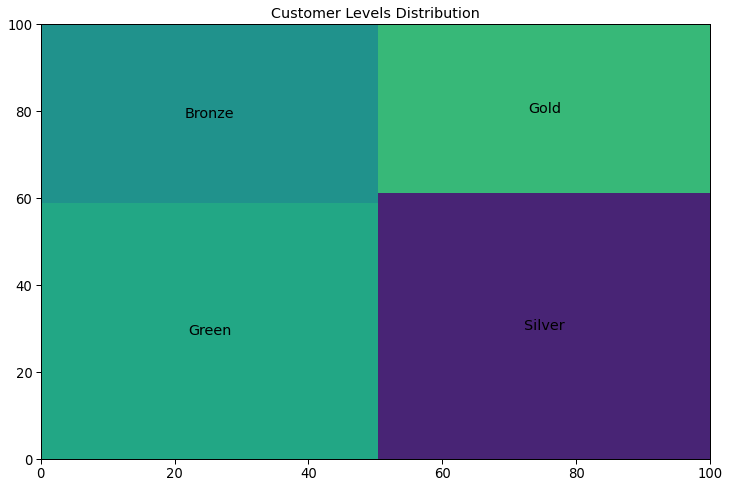

In [44]:
#let's exclude others segment for visualization
levels = list(retail_rfm_levels.RFM_Level)
score = list(retail_rfm_levels.counts)
plt.figure(figsize=(12,8))
plt.title('Customer Levels Distribution')
squarify.plot(sizes=score, label=levels)

plt.show()

In [45]:
#let's try to do more detailed segmentation
segment_dict = {    
    'Best Customers':'444',      # Highest frequency as well as monetary value with least recency
    'Loyal Customers':'344',     # High frequency as well as monetary value with good recency
    'Potential Loyalists':'434', # High recency and monetary value, average frequency
    'Big Spenders':'334',        # High monetary value but good recency and frequency values
    'At Risk Customers':'244',   # Customer's shopping less often now who used to shop a lot
    'Can’t Lose Them':'144',      # Customer's shopped long ago who used to shop a lot.
    'Recent Customers':'443',    # Customer's who recently started shopping a lot but with less monetary value
    'Lost Cheap Customers':'122' # Customer's shopped long ago but with less frequency and monetary value
}

In [46]:
# Swap the key and value of dictionary
dict_segment = dict(zip(segment_dict.values(),segment_dict.keys()))

# Allocate segments to each customer as per the RFM score mapping
retail_rfm['Segment'] = retail_rfm.RFM_Segment.map(lambda x: dict_segment.get(x))

In [47]:
# Allocate all remaining customers to others segment category
retail_rfm.Segment.fillna('others', inplace=True)

In [48]:
retail_rfm.sample(10)

,CustomerID,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,RFM_Level,Segment
1728,14680.0,24,320,26932.34,3,4,4,344,11.0,Gold,Loyal Customers
59,12421.0,15,46,806.27,4,3,3,433,10.0,Silver,others
1925,14960.0,7,27,221.27,4,2,1,421,7.0,Bronze,others
1215,13980.0,59,11,200.14,2,1,1,211,4.0,Green,others
2615,15870.0,32,74,351.44,3,3,2,332,8.0,Silver,others
2765,16093.0,106,1,17.00,2,1,1,211,4.0,Green,others
1031,13727.0,28,20,333.48,3,2,2,322,7.0,Bronze,others
3273,16773.0,56,26,171.59,2,2,1,221,5.0,Green,others
146,12526.0,0,71,1316.66,4,3,3,433,10.0,Silver,others
935,13590.0,10,89,1976.12,4,3,4,434,11.0,Gold,Potential Loyalists


In [49]:
retail_rfm_segments = retail_rfm[retail_rfm.Segment!='other'].groupby('Segment')['CustomerID'].count().reset_index(name='counts')
retail_rfm_segments.iloc[:8]

,Segment,counts
0,At Risk Customers,105
1,Best Customers,470
2,Big Spenders,57
3,Can’t Lose Them,21
4,Lost Cheap Customers,204
5,Loyal Customers,210
6,Potential Loyalists,79
7,Recent Customers,85


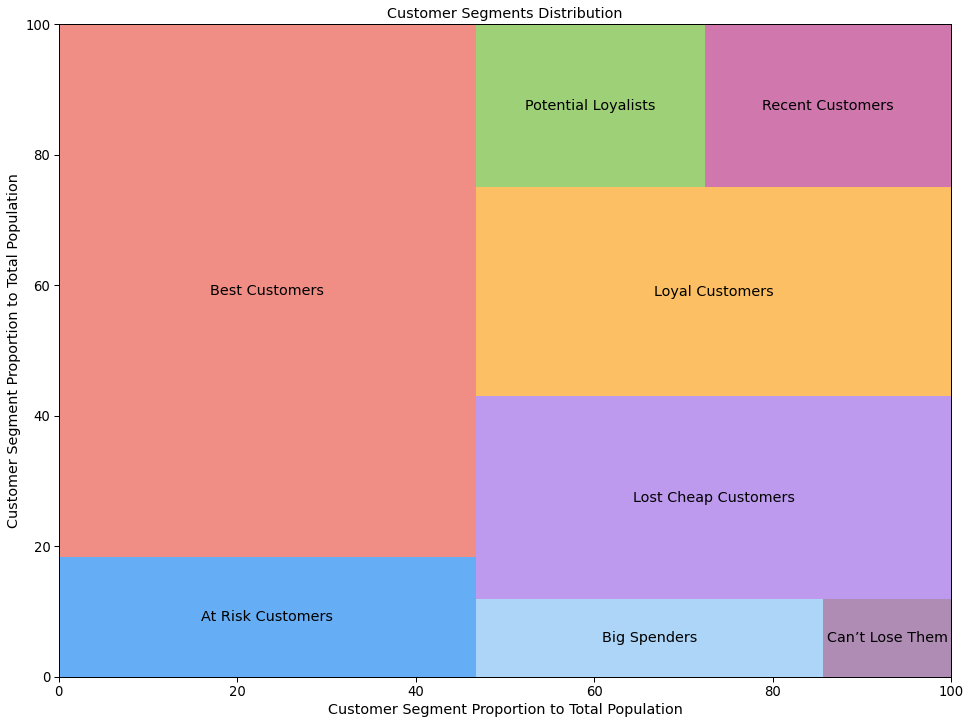

In [51]:
import matplotlib
import matplotlib.pyplot as plt

#let's exclude others segment for visualization
segment = list(retail_rfm_segments.iloc[:8].Segment)
score = list(retail_rfm_segments.iloc[:8].counts)

# create a color palette, mapped to these values
cmap = matplotlib.cm.GnBu
mini=min(score)
maxi=max(score)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
color_list = ["#248af1", "#eb5d50", "#8bc4f6", "#8c5c94", "#a170e8", "#fba521", "#75bc3f", "#bc3f8c"]
 
plt.figure(figsize=(16,12))
plt.xlabel("Customer Segment Proportion to Total Population")
plt.ylabel("Customer Segment Proportion to Total Population")
plt.title('Customer Segments Distribution')
squarify.plot(sizes=score, label=segment,color=color_list, alpha=0.7)

plt.show()